In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('takehome_user_engagement.csv')
user_data = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
data.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
user_data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
# Converting time_stamp column to datetime object for further operation
data['time_stamp'] = pd.to_datetime(data['time_stamp'])

In [6]:
# Setting index
data.set_index('time_stamp', inplace=True)

In [7]:
# Finding adopted user who has logged into the product on three separate days in at least one sevenday period
def find_adopted(x):
    
    df = data.loc[data['user_id'] == x]
    df = df.resample('D').mean().dropna()
    adopted = 0
    for i in range(len(df)-2): #loop over active days till the second to last day
        if df.index[i + 2] - df.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [8]:
user_data['adopted'] = user_data['object_id'].apply(find_adopted)

In [9]:
print('Out of {} users, {} were adopted which is approximately {}% of total population'.
      format(len(user_data), sum(user_data['adopted']), round((sum(user_data['adopted'])/len(user_data['adopted']))* 100)))

Out of 12000 users, 1656 were adopted which is approximately 14% of total population


Converting creation_time column into datetime object <br>
converting last_session_creation_time column to creation_time format for further opeartion

In [10]:
user_data['creation_time'] = pd.to_datetime(user_data['creation_time'])
user_data['last_session_creation_time'] = user_data['last_session_creation_time'].map(lambda data: datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'), na_action='ignore')

In [11]:
user_data['last_session_creation_time'] = pd.to_datetime(user_data['last_session_creation_time'])

In [12]:
user_data['login_activity'] = user_data['last_session_creation_time'] - user_data['creation_time']
user_data['login_activity'] = [x.total_seconds() for x in user_data['login_activity']] # need total seconds

In [13]:
# Extracting Email IDs
user_data['email_provider'] = [email.split('@')[1] for email in user_data['email']]

In [14]:
# Extracting top 6 Email Provider
top_email_provider = user_data.email_provider.value_counts()[:6].index

In [15]:
user_data['email_provider'] = [email if email in top_email_provider else 'other' for email in user_data.email_provider]

In [16]:
# Imputing missing data
user_data.invited_by_user_id = user_data.invited_by_user_id.fillna(0)
user_data.login_activity = user_data.login_activity.fillna(0)

In [17]:
# Converting categorical input to numerical for fitting into model
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(user_data['creation_source'])
user_data.creation_source = creation_labels

org_id_labels = gle.fit_transform(user_data['org_id'])
user_data.org_id = org_id_labels

invited_labels = gle.fit_transform(user_data['invited_by_user_id'])
user_data.org_id = invited_labels

email_labels = gle.fit_transform(user_data['email_provider'])
user_data.email_provider = email_labels

In [18]:
user_data = user_data.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time'], axis = 1)

In [19]:
user_data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,login_activity,email_provider
0,0,1,0,2325,10803.0,0,19800.0,6
1,1,0,0,56,316.0,1,11770200.0,2
2,1,0,0,298,1525.0,0,19800.0,2
3,0,0,0,1104,5151.0,0,106200.0,6
4,0,0,0,1127,5240.0,0,451800.0,6


In [20]:
X = user_data.drop(['adopted'], axis = 1)
y = user_data['adopted']

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=10)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9707070707070707

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.91      0.87      0.89       553

    accuracy                           0.97      3960
   macro avg       0.95      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960



In [25]:
confusion_matrix(y_test, rf.predict(X_test))

array([[3362,   45],
       [  71,  482]], dtype=int64)

In [33]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(X.columns)
feature_importance.coef.nlargest(10)

login_activity                0.928490
invited_by_user_id            0.022318
org_id                        0.018947
email_provider                0.013410
creation_source               0.009584
enabled_for_marketing_drip    0.003730
opted_in_to_mailing_list      0.003522
Name: coef, dtype: float64

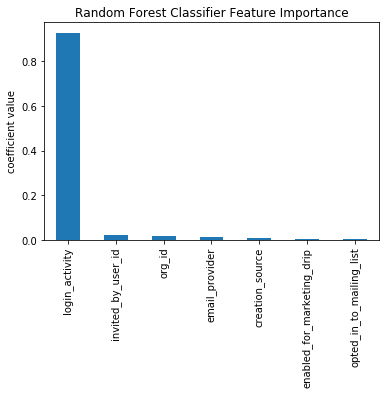

In [34]:
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

It is clear that login_ativity is playing critical role while predicting future user adoption

In [26]:
#define func to find ecdf of dataset
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [27]:
adopted = user_data.login_activity.loc[user_data['adopted'] == 1]
not_adopted = user_data.login_activity.loc[user_data['adopted'] == 0]

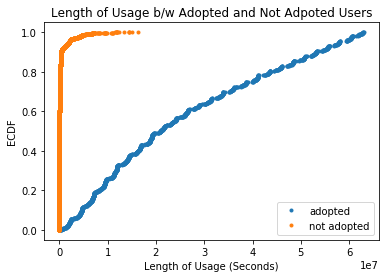

In [28]:
x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('Usage b/w Adopted and Not Adpoted Users')
plt.xlabel('Usage in (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

Adopted user generally spend more time than non adopted user.